In [128]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [124]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Read data

In [7]:
# Read preprocessed
df = pd.read_csv(os.path.join(data_path, "preprocessed.csv"), index_col=0)
df.index = pd.to_datetime(df.index)

In [8]:
df[['rlm', 'slp']].mean() * 365 #/ df[['slp', 'rlm']].sum().sum()

rlm    587.060876
slp    408.409846
dtype: float64

In [9]:
df.head().transpose()

,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05
slp,2.302289,2.362777,2.284347,2.203892,2.509253
rlm,1.673442,2.056043,2.030095,2.108759,2.358004
industry,1.430437,1.645854,1.691689,1.761544,1.788436
gas_to_electricity,0.325731,0.549828,0.453608,0.465417,0.763463
electricity_from_gas,0.139161,0.234902,0.193794,0.198839,0.326173
gas_price [€/MWh],NaN,NaN,NaN,NaN,NaN
producing_sector,91.7,91.7,91.7,91.7,91.7
manufacturing_sector,94.8,94.8,94.8,94.8,94.8
hospitality_sector,82.6,82.6,82.6,82.6,82.6
retail_sector,96.1,96.1,96.1,96.1,96.1


# Prepare regression data

In [26]:
dfx = df.copy()
dfx = dfx.rename(columns={
    'aggregated': 'w2h',
    'electricity_from_gas': 'power',
    'producing_sector': 'prod',
    'manufacturing_sector': 'manu',
    'retail_sector': 'retail',
    'hospitality_sector': 'hosp',
    'gas_price [€/MWh]': 'prices',
    'Temp [K]': 'temp'
})

dfx['log_slp'] = np.log(dfx['slp'])
dfx['log_rlm'] = np.log(dfx['rlm'])
dfx['log_industry'] = np.log(dfx['industry'])
dfx['power2'] = dfx['power'].apply(lambda x: x**2)

dfx = dfx[
    (dfx.holiday==0) & 
    (dfx.christmas_period==0) & 
    (dfx.bridgeday==0)
]

# Cut December 22-23
dfx = dfx[((dfx.index.month!=12)|(dfx.index.day<22))]

# Cut corona
# covid_beginning = "2020-02-01" --> lockdown started on 13 March 2020
#dfx = dfx[(dfx.index < '2020-03-01')|(dfx.index >= '2021-05-01')]
# invasion_date = "2022-02-24"

In [27]:
def model(dependent_variable, control_list):
    
    m = f'{dependent_variable} ~ 1 + time + C(month) + C(weekday) + ' + ' + '.join(control_list)
    print(m)
    return smf.ols(m, dfx.loc[fitting_start:]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

In [28]:
def all_models(dummy_list, consumer='rlm', further_controls=False, econ=False):
    
    results = {}
    
    names = ['naive', 'temp',]
    if econ:
        names += ['temp+econ']
    if consumer=='rlm':
        names += ['temp+econ+power']
    
    for name in names:
    
        control_list = [d for d in dummy_list]        
        if 'temp' in name:
            control_list += ['residential','commercial','time*residential','solar']
#        if 'temp' in name:
#            control_list += 'w2h','time*w2h','temp,'solar']
        if 'econ' in name:
            control_list += ['manu','prod'] if (consumer=='rlm' or consumer=='industry') else ['hosp','retail']
        if 'power' in name:
            control_list += ['power']
        
        results[name] = model(f'{"log_" if log else ""}{consumer}', control_list)

    return results

In [29]:
def extract_results(dummy_list, results):
    
    extracted_results = pd.concat(
        [results.params, results.bse], keys=['coef', 'se'], axis=1
    )
    
    extracted_results = extracted_results*100 if log else extracted_results
    extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
    extracted_results.index = dummy_list
    extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
    extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
    
    return extracted_results

# One crisis dummy

In [30]:
def plot_waterfall(ax, results, consumer='rlm', ylabel=''):

    colors = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', 'tab:red']
    
    for i, (name, res) in enumerate(results.items()):
        
        # first bar
        if i==0:
            ax.bar(i, res['coef'], alpha=0.5, color=colors[i])
            ax.plot([i,i], [res['low'], res['high']], color=colors[i])
        
        # waterfall
        if i > 0:
            ax.bar(i, res['coef'] - previous_coef, bottom=previous_coef, alpha=0.5, color=colors[i])    
            ax.plot([i-1.4,i+0.4], [previous_coef, previous_coef], color='black', linewidth=0.7, linestyle='--')
            ax.plot([i-0.4,i+1.4], [res['coef'], res['coef']], color='black', linewidth=0.7, linestyle='--')
            
        previous_coef = res['coef']
    
    # last bar
    i += 1
    ax.bar(i, res['coef'], alpha=0.5, color=colors[-1])
    ax.plot([i,i], [res['low'], res['high']], color=colors[-1])
    
    ax.grid(axis='y')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel(ylabel)
    title_conversion = {
        'slp':'Small consumers',
        'rlm':'Large consumers',
        'industry':'Industrial consumers',    
    }
    ax.set_title(title_conversion[consumer])    
    if log:
        ax.set_ylim(-21, 7)
        
    labels = ['Overall\nchange', 'Temperature']
    if 'temp+econ' in results.keys():
        labels += ['Economic\nactivity']
    if consumer=='rlm': 
        labels += ['Power\nsector']
    ax.set_xticks(range(len(results)+1))
    ax.set_xticklabels((labels + ['Crisis\nresponse']))

In [31]:
def one_dummy(further_controls=False, econ=False):
    
    dummy_list=['crisis']
    dfx['crisis'] = dfx.index.map(lambda x: x >= crisis_start)

    results = {
        consumer: all_models(dummy_list, consumer, further_controls=further_controls, econ=econ) 
        for consumer in ['slp', 'industry']
    }
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4.5), sharey='row', gridspec_kw={'width_ratios': [1,1.4]})

    res = {m: extract_results(dummy_list, value) for m, value in results['slp'].items()}
    ax1 = plot_waterfall(ax1, res, 'slp', 'Estimated change in demand ' + ('(%)' if log else '(TWh/d)'))

    res = {m: extract_results(dummy_list, value) for m, value in results['industry'].items()}
    ax2 = plot_waterfall(ax2, res, 'industry')

    plt.tight_layout()
    
    return results

## Main Specification

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod


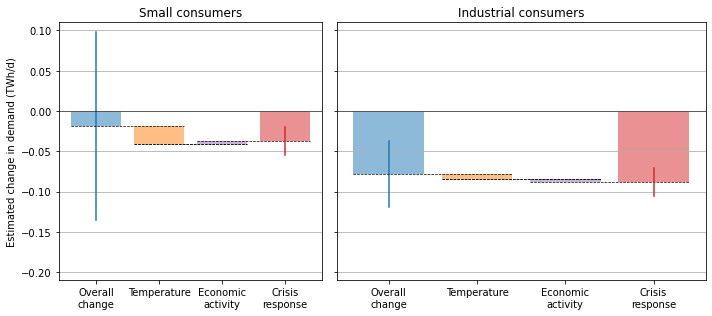

In [32]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results = one_dummy(econ=True)
plt.ylim(-.21, .11)
plt.savefig(f'one_dummy.png', dpi=300)

In [ ]:
#gas_to_electricity_public ~ 1 + time + C(month) + C(weekday) + time*temp + temp(-3) + solar + crisis

In [22]:
results['industry']['temp+econ'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               industry   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     728.7
Date:                Thu, 14 Jul 2022   Prob (F-statistic):               0.00
Time:                        10:56:59   Log-Likelihood:                 2420.8
No. Observations:                1787   AIC:                            -4790.
Df Residuals:                    1761   BIC:                            -4647.
Df Model:                          25                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.0935      0.067     16.300      0.000       0.962       1.225
C(month)[T.2]              -0.0082      0.013     -0.641      0.522      -0.033       0.017
C(month)[T.3]              -0.0432      0.022     -1.941      0.052      -0.087       0.000
C(month)[T.4]              -0.0902      0.024     -3.839      0.000      -0.136      -0.044
C(month)[T.5]              -0.0790      0.025     -3.207      0.001      -0.127      -0.031
C(month)[T.6]              -0.0818      0.027     -3.039      0.002      -0.135      -0.029
C(month)[T.7]              -0.0998      0.029     -3.441      0.001      -0.157      -0.043
C(month)[T.8]              -0.1121      0.028     -3.985      0.000      -0.167      -0.057
C(month)[T.9]              -0.0793      0.027     -2.884      0.004      -0.133      -0.025
C(month)[T.10]             -0.0258      0.029     -0.896      0.371      -0.082       0.031
C(month)[T.11]             -0.0017      0.029     -0.058      0.954      -0.059       0.056
C(month)[T.12]              0.0175      0.033      0.532      0.595      -0.047       0.082
C(weekday)[T.Monday]        0.0591      0.006     10.708      0.000       0.048       0.070
C(weekday)[T.Saturday]     -0.1179      0.005    -24.110      0.000      -0.128      -0.108
C(weekday)[T.Sunday]       -0.0788      0.006    -14.287      0.000      -0.090      -0.068
C(weekday)[T.Thursday]      0.0443      0.004     10.450      0.000       0.036       0.053
C(weekday)[T.Tuesday]       0.0460      0.006      8.030      0.000       0.035       0.057
C(weekday)[T.Wednesday]     0.0507      0.005      9.959      0.000       0.041       0.061
crisis[T.True]             -0.0880      0.009     -9.940      0.000      -0.105      -0.071
time                     2.549e-05   9.99e-06      2.551      0.011     5.9e-06    4.51e-05
residential                 0.2033      0.070      2.923      0.003       0.067       0.340
commercial                  0.4357      0.137      3.174      0.002       0.167       0.705
time:residential         4.462e-06   9.81e-06      0.455      0.649   -1.48e-05    2.37e-05
solar                      -0.2939      0.052     -5.677      0.000      -0.395      -0.192
manu                        0.0072      0.004      1.722      0.085      -0.001       0.015
prod                       -0.0077      0.005     -1.626      0.104      -0.017       0.002
==============================================================================
Omnibus:                       23.431   Durbin-Watson:                   0.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.391
Skew:                           0.176   Prob(JB):                     2.52e-07
Kurtosis:                       3.533   Cond. No.                     1.37e+05
====================

In [120]:
# year-on-year
ref_industry = dfx[(dfx.index >= '2020-08-01') & (dfx.index < '2021-05-01')]['industry'].mean()  #, (338+58)/(338+141+58))
0.0880 / ref_industry #temp+econ

0.06469215160214883

Industrial consumers: 0.0880 TWh/d is 6% of 1.4 TWh/d avg. demand during months 8-3 before crisis

In [23]:
results['slp']['temp+econ'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    slp   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     9170.
Date:                Wed, 13 Jul 2022   Prob (F-statistic):               0.00
Time:                        11:17:10   Log-Likelihood:                 2961.8
No. Observations:                1787   AIC:                            -5872.
Df Residuals:                    1761   BIC:                            -5729.
Df Model:                          25                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.2972      0.075      3.951      0.000       0.150       0.445
C(month)[T.2]               0.0027      0.010      0.274      0.784      -0.017       0.022
C(month)[T.3]              -0.0590      0.015     -3.920      0.000      -0.089      -0.030
C(month)[T.4]              -0.1428      0.015     -9.590      0.000      -0.172      -0.114
C(month)[T.5]              -0.1781      0.018    -10.120      0.000      -0.213      -0.144
C(month)[T.6]              -0.1856      0.018    -10.040      0.000      -0.222      -0.149
C(month)[T.7]              -0.1902      0.019    -10.120      0.000      -0.227      -0.153
C(month)[T.8]              -0.1915      0.017    -11.005      0.000      -0.226      -0.157
C(month)[T.9]              -0.1848      0.017    -10.725      0.000      -0.219      -0.151
C(month)[T.10]             -0.1428      0.017     -8.395      0.000      -0.176      -0.109
C(month)[T.11]             -0.0814      0.019     -4.367      0.000      -0.118      -0.045
C(month)[T.12]             -0.0055      0.023     -0.241      0.810      -0.050       0.039
C(weekday)[T.Monday]       -0.0086      0.004     -2.427      0.015      -0.016      -0.002
C(weekday)[T.Saturday]      0.0039      0.003      1.332      0.183      -0.002       0.010
C(weekday)[T.Sunday]        0.0057      0.004      1.576      0.115      -0.001       0.013
C(weekday)[T.Thursday]     -0.0037      0.003     -1.421      0.155      -0.009       0.001
C(weekday)[T.Tuesday]      -0.0070      0.004     -1.878      0.060      -0.014       0.000
C(weekday)[T.Wednesday]    -0.0048      0.003     -1.471      0.141      -0.011       0.002
crisis[T.True]             -0.0371      0.009     -4.339      0.000      -0.054      -0.020
time                     1.669e-05   1.05e-05      1.591      0.112   -3.87e-06    3.72e-05
residential                 0.7415      0.049     14.981      0.000       0.644       0.838
commercial                  1.3732      0.096     14.253      0.000       1.184       1.562
time:residential         4.631e-05   8.06e-06      5.742      0.000    3.05e-05    6.21e-05
solar                      -0.0072      0.037     -0.193      0.847      -0.080       0.066
hosp                       -0.0001      0.000     -0.999      0.318      -0.000       0.000
retail                     -0.0006      0.001     -0.847      0.397      -0.002       0.001
==============================================================================
Omnibus:                       43.175   Durbin-Watson:                   0.587
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.218
Skew:                           0.088   Prob(JB):                     1.56e-20
Kurtosis:                       4.093   Cond. No.                     1.37e+05
====================

In [119]:
# all data
#ref = dfx[(dfx.index < crisis_start) & (dfx.index.month.isin([8,9,10,11,12,1,2,3]))]['rlm'].mean()

# year-on-year
ref_slp = dfx[(dfx.index >= '2020-08-01') & (dfx.index < '2021-05-01')]['slp'].mean()  #, (338+58)/(338+141+58))
0.0371 / ref_slp #temp+econ

0.02676706481513163

Small consumers: 0.0371 TWh/d is 3% of 1.4 TWh/d avg. demand during months 8-3 before crisis

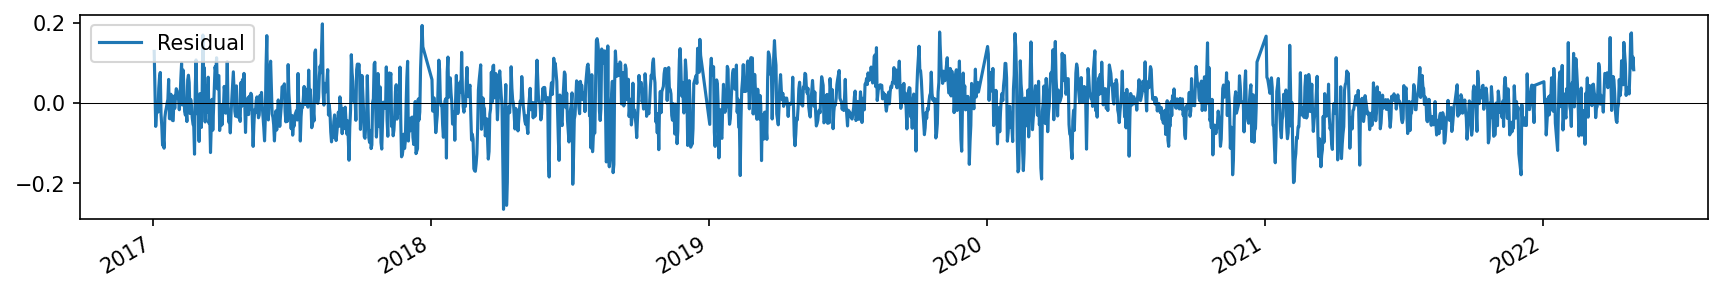

In [29]:
resid = results['industry']['temp+econ'].fittedvalues - dfx['industry'] 

plt.figure(figsize=(14, 2), dpi=150)
#results['rlm']['temp+power+econ'].fittedvalues.plot(label='Fitted')
#dfx['rlm'].plot(label='Observed')
resid.plot(label='Residual')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend(loc='upper left')

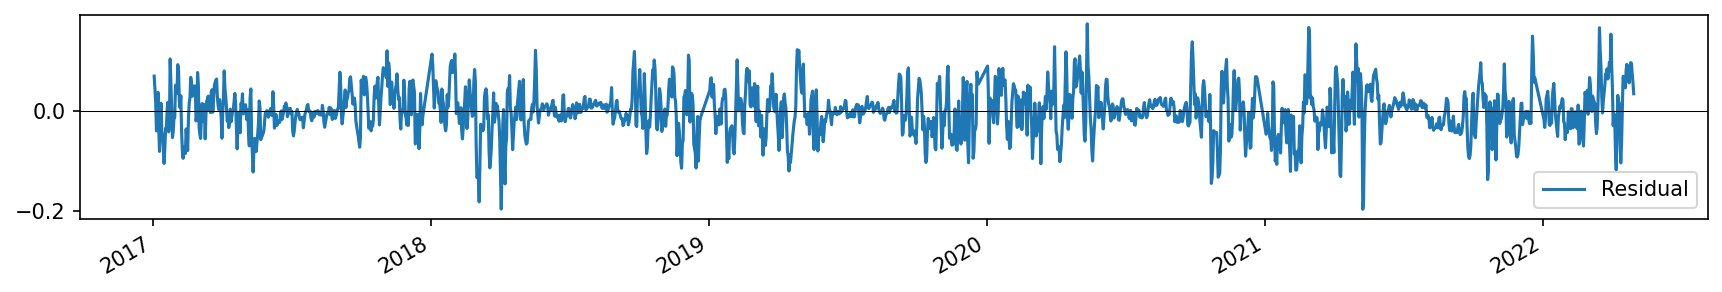

In [28]:
resid = results['slp']['temp+econ'].fittedvalues - dfx['slp'] 

plt.figure(figsize=(14, 2), dpi=150)
#results['slp']['temp+econ'].fittedvalues.plot(label='Fitted')
#dfx['slp'].plot(label='Observed')
resid.plot(label='Residual')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()

## Sensitivities

Crisis start: 1-2 month later crisis start does not change a lot, but including June-July significantly reduces average response of small & industial consumers

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod


(-0.21, 0.11)

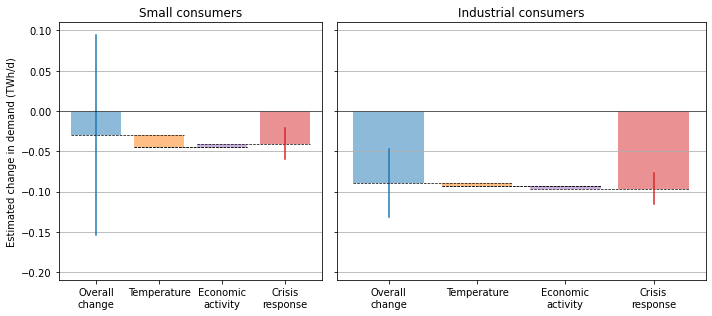

In [46]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-09-01" #default: 2021-08-01
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod


(-0.21, 0.11)

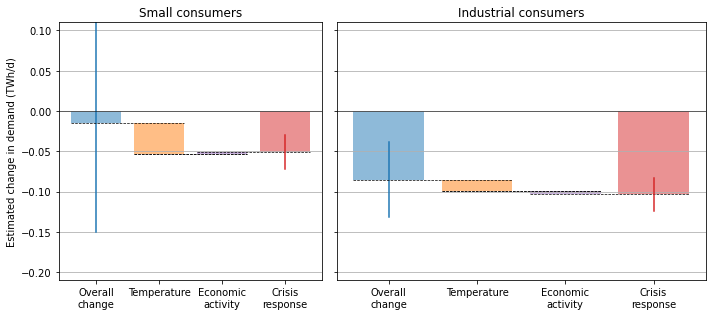

In [147]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-10-01" #default: 2021-08-01
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod


(-0.21, 0.11)

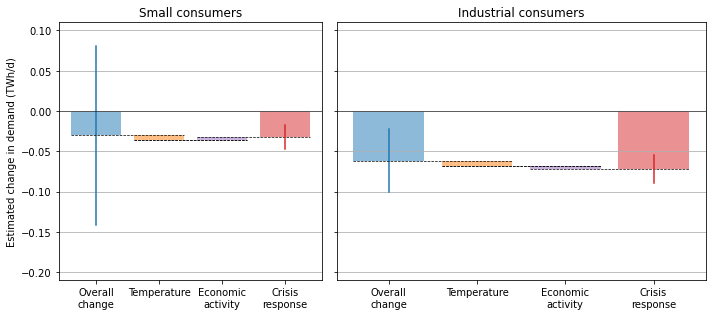

In [151]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-06-01" #default: 2021-08-01
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

Fitting period: Quite sensitive to change in fitting period, crisis response of industrial consumers increases with reduced fitting period while small consumers' response is rather stable

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod


(-0.21, 0.11)

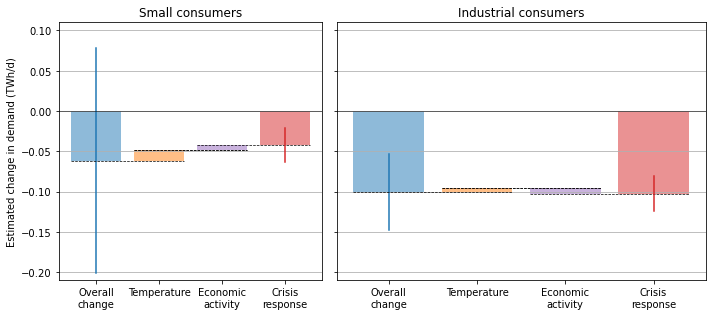

In [153]:
log=False
fitting_start = "2018-01-01" #default: 2017-01-01
crisis_start = "2021-09-01" 
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod


(-0.21, 0.11)

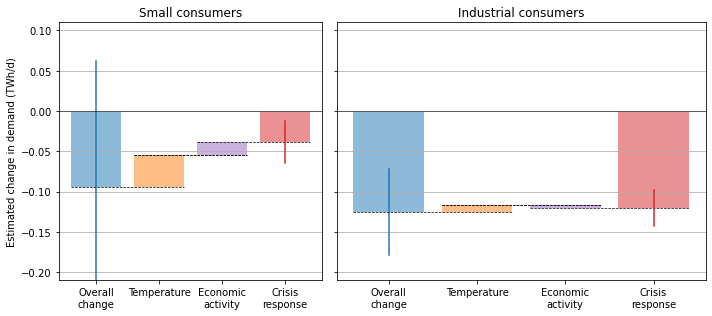

In [154]:
log=False
fitting_start = "2019-01-01" #default: 2017-01-01
crisis_start = "2021-09-01" 
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod


(-0.25, 0.11)

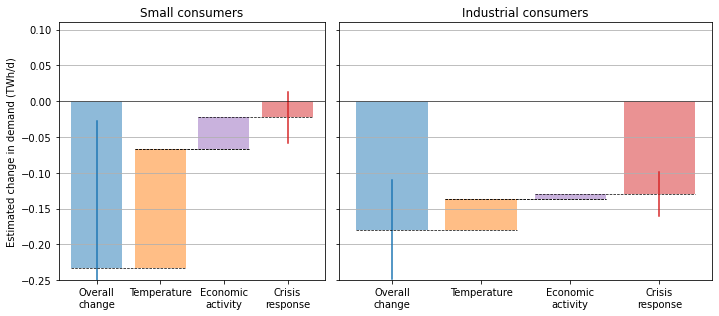

In [162]:
log=False
fitting_start = "2020-01-01" #default: 2017-01-01
crisis_start = "2021-09-01" 
results = one_dummy(econ=True)
plt.ylim(-.25, .11)

Add/remove control variables: Omitting economic activity does not change a lot

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar


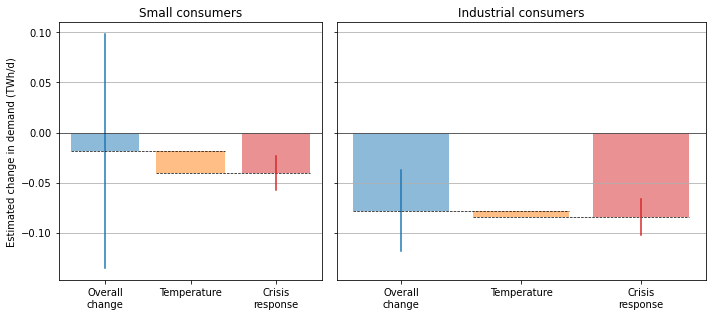

In [47]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results = one_dummy(econ=False)

# Quarterly dummies (not currently used)

In [33]:
mode = 'quarterly'
crisis_start = "2021-09-01"
dummy_list = []
for date in pd.date_range(crisis_start, '2022-04', freq='3m'):
    dummy_name = f'd{date.year}_{date.quarter}'
    dfx.loc[dfx.index, dummy_name] = dfx.index.map(
        lambda x: (x.year==date.year) & (x.quarter==date.quarter)
    ).values
    dummy_list.append(dummy_name)

# Monthly dummies

In [34]:
mode = 'monthly'
crisis_start = "2021-05-01"
dummy_list = []
for date in pd.date_range(crisis_start, '2022-05', freq='1m'):
    dummy_name = f'd{date.year}_{date.month}'
    dfx.loc[dfx.index, dummy_name] = dfx.index.map(
        lambda x: (x.year==date.year) & (x.month==date.month)
    ).values
    dummy_list.append(dummy_name)

In [145]:
def plot_monthly(ax, results, consumer='rlm', ylabel='Crisis response (TWh/d)', names=None):

    colors = {
        'naive': 'tab:blue',
        'temp+econ': ('tab:orange' if consumer=='rlm' else 'tab:red'),
        'temp+econ+power': 'tab:red'
    }
    extracted_results = {m: extract_results(dummy_list, value) for m, value in results[consumer].items()}
    
    if names==None:
        names = extracted_results.keys()
    
    for i, name in enumerate(names):
        
        res = extracted_results[name]
        
        idx = [j-0.15*(len(names)-1)+0.6/len(names)*i for j in range(len(res))]
        ax.bar(idx, res['coef'], width=0.6/len(names),alpha=0.5, label=name, color=colors[name])
        for j, d in enumerate(dummy_list):
            ax.plot([idx[j], idx[j]], [res.loc[d, 'low'], res.loc[d, 'high']], 
                     color=colors[name])
    ax.grid(axis='y')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel(ylabel)
    ax.set_ylim(-0.2, 0.1)
    title_conversion = {
        'slp':'Small consumers',
        'rlm':'Large consumers',
        'industry':'Industrial consumers',    
    }
    ax.set_title(title_conversion[consumer])
    if mode=='monthly':
        ax.set_xticks(
            range(len(res)), 
            [f'{date.month_name()[:3]}'+(f'\n{date.year}' if ((date.month==1) | (i==0)) else '')
             for i, date in enumerate(pd.date_range(crisis_start, '2022-05', freq='1m'))]
        )
    
    ax.axvline(7.5, color='black', linewidth=0.5)

In [136]:
log=False
results = {consumer: all_models(dummy_list, consumer, econ=True) for consumer in ['slp', 'industry']}

slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + commercial + time*residential + solar
in

TypeError: set_ticks() takes 2 positional arguments but 3 were given

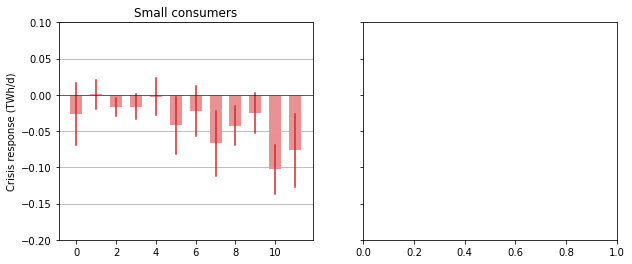

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey='row', gridspec_kw={'width_ratios': [1,1]})

plot_monthly(ax1, results, 'slp', names=['temp+econ'])
#ax1.text(10.5, 0.02, 'Invasion\nof Ukraine', horizontalalignment='center')

plot_monthly(ax2, results, names=['temp+econ'], ylabel='')
#ax2.text(4.5, 0.02, 'TTF prices\nall-time-high', horizontalalignment='center')

plt.tight_layout()
plt.savefig('months.png')

In [98]:
results['rlm']['temp+econ+power'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rlm   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     1830.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):               0.00
Time:                        13:55:09   Log-Likelihood:                 2795.6
No. Observations:                1787   AIC:                            -5515.
Df Residuals:                    1749   BIC:                            -5307.
Df Model:                          37                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.0851      0.063     17.242      0.000       0.962       1.208
C(month)[T.2]              -0.0130      0.014     -0.916      0.360      -0.041       0.015
C(month)[T.3]              -0.0712      0.022     -3.270      0.001      -0.114      -0.029
C(month)[T.4]              -0.0987      0.025     -4.019      0.000      -0.147      -0.051
C(month)[T.5]              -0.1015      0.026     -3.919      0.000      -0.152      -0.051
C(month)[T.6]              -0.0886      0.026     -3.376      0.001      -0.140      -0.037
C(month)[T.7]              -0.0925      0.030     -3.103      0.002      -0.151      -0.034
C(month)[T.8]              -0.1156      0.028     -4.068      0.000      -0.171      -0.060
C(month)[T.9]              -0.0873      0.026     -3.399      0.001      -0.138      -0.037
C(month)[T.10]             -0.0326      0.029     -1.107      0.268      -0.090       0.025
C(month)[T.11]             -0.0201      0.029     -0.684      0.494      -0.077       0.037
C(month)[T.12]              0.0038      0.034      0.114      0.910      -0.062       0.070
C(weekday)[T.Monday]        0.0550      0.005     11.972      0.000       0.046       0.064
C(weekday)[T.Saturday]     -0.1553      0.005    -34.403      0.000      -0.164      -0.146
C(weekday)[T.Sunday]       -0.1329      0.006    -22.963      0.000      -0.144      -0.122
C(weekday)[T.Thursday]      0.0505      0.003     15.160      0.000       0.044       0.057
C(weekday)[T.Tuesday]       0.0524      0.004     11.656      0.000       0.044       0.061
C(weekday)[T.Wednesday]     0.0571      0.004     14.217      0.000       0.049       0.065
d2021_5[T.True]             0.0035      0.011      0.324      0.746      -0.018       0.025
d2021_6[T.True]            -0.0085      0.011     -0.745      0.456      -0.031       0.014
d2021_7[T.True]            -0.0504      0.019     -2.687      0.007      -0.087      -0.014
d2021_8[T.True]            -0.0923      0.012     -7.489      0.000      -0.117      -0.068
d2021_9[T.True]            -0.0960      0.010     -9.252      0.000      -0.116      -0.076
d2021_10[T.True]           -0.1400      0.014    -10.052      0.000      -0.167      -0.113
d2021_11[T.True]           -0.0794      0.013     -6.306      0.000      -0.104      -0.055
d2021_12[T.True]           -0.0726      0.018     -4.134      0.000      -0.107      -0.038
d2022_1[T.True]            -0.1108      0.016     -7.130      0.000      -0.141      -0.080
d2022_2[T.True]            -0.1419      0.016     -8.719      0.000      -0.174      -0.110
d2022_3[T.True]            -0.1376      0.014     -9.511      0.000      -0.166      -0.109
d2022_4[T.True]            -0.1920      0.016    -11.748      0.000      -0.224      -0.160
time                      4.95e-05   1.25e-05  

In [69]:
0.075 / (dfx[(dfx.index.year==2022) & (dfx.index.month.isin([4]))]['slp'].mean() + 0.075)

0.057852575384981834

## Augmented Dickey-Fuller test for stationarity

In [ ]:
print(adfuller(df_x_no_holiday['rlm'].dropna(), regression='nc'))

# p = 0.04910444772233917 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however)

print(adfuller(df_x_no_holiday['slp_w2h'].dropna(), regression='c'))

# we can only reject at 10% confidence level but this might change if bug in 2022 data is fixed

print(adfuller(df_x_no_holiday['power'].dropna(), regression='c'))

# p = 0.0011084722880644524 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however))

print(adfuller(df_x_no_holiday['power'].dropna(), regression='c'))

# p = 6.344246220602208e-05 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however)

## KPSS test for stationarity

In [ ]:
kpss(df_x_no_holiday['rlm'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['w2h'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['power'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['econ'].dropna(), regression='c')

# p is very large -> we have to reject the null that the the process is (level) stationary
# CHECK: this is counterintuitive as the DF test finds the opposite